# Deblending

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pylops

from scipy.sparse.linalg import lobpcg as sp_lobpcg
from pylops import LinearOperator
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.blending  import *
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import fista

parallel True


Load the data

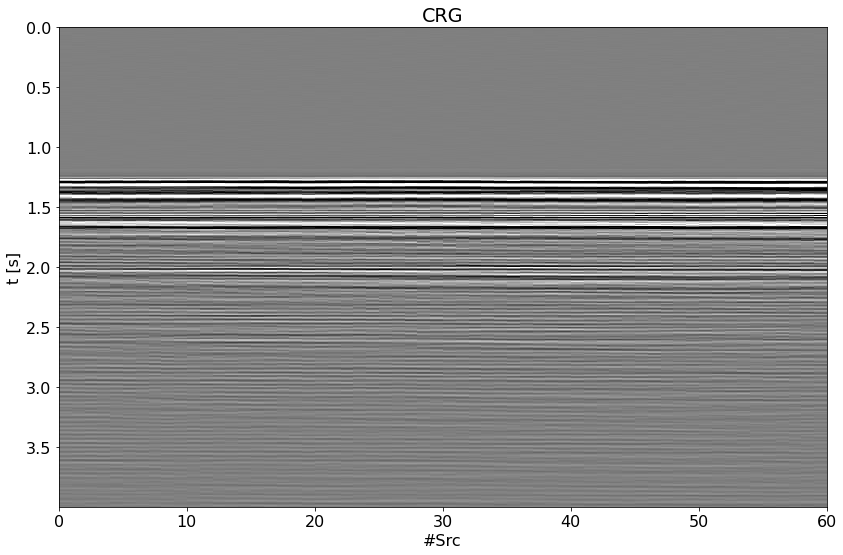

In [2]:
data = np.load("../../pylops/testdata/deblending/mobil.npy")
ns, nt = data.shape

dt = 0.004
t = np.arange(nt) * dt

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(
    data.T,
    cmap="gray",
    vmin=-50,
    vmax=50,
    extent=(0, ns, t[-1], 0),
    interpolation="none",
)
ax.set_title("CRG")
ax.set_xlabel("#Src")
ax.set_ylabel("t [s]")
ax.axis("tight")
plt.tight_layout();

## Continuous blending

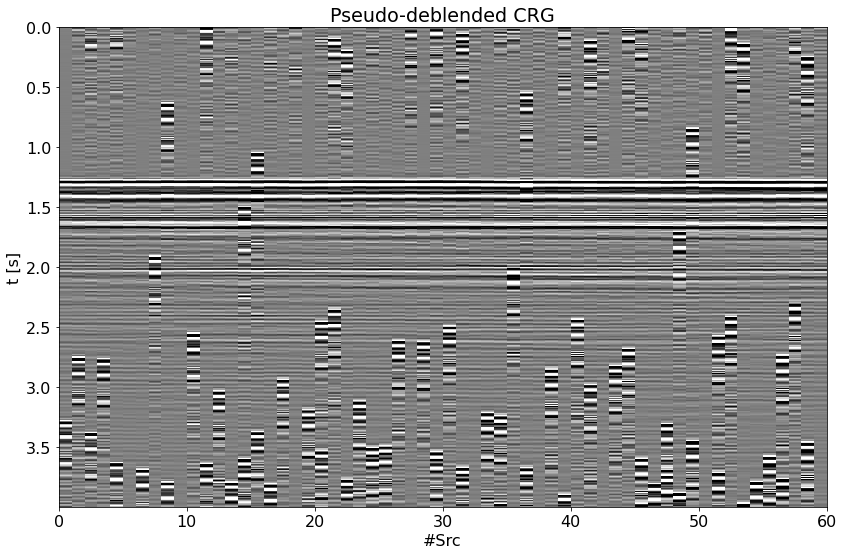

In [3]:
overlap = 0.5
ignition_times = 2.0 * np.random.rand(ns) - 1.0
ignition_times1 = np.arange(0, overlap * nt * ns, overlap * nt) * dt + ignition_times
ignition_times1[0] = 0.
Bop = BlendingContinuous(nt, 1, ns, dt, ignition_times1, dtype="complex128")

data_blended = Bop * data[:, np.newaxis]
data_pseudo = Bop.H * data_blended

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(
    data_pseudo.squeeze().T.real,
    cmap="gray",
    vmin=-50,
    vmax=50,
    extent=(0, ns, t[-1], 0),
    interpolation="none",
)
ax.set_title("Pseudo-deblended CRG")
ax.set_xlabel("#Src")
ax.set_ylabel("t [s]")
ax.axis("tight")
plt.tight_layout()

FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 30388 rows and 998400 cols
eps = 5.000000e+00	tol = 1.000000e-10	niter = 60
alpha = 3.287563e-01	thresh = 8.218908e-01
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1   -0.00e+00+0.00e+00j    3.294e+06   4.959e+06   1.297e+03
     2   -0.00e+00+0.00e+00j    1.875e+06   4.208e+06   6.672e+02
     3   -0.00e+00+0.00e+00j    1.109e+06   3.840e+06   5.468e+02
     4   -0.00e+00+0.00e+00j    7.069e+05   3.624e+06   4.482e+02
     5   -0.00e+00+0.00e+00j    4.926e+05   3.454e+06   3.791e+02
     6   -0.00e+00+0.00e+00j    3.741e+05   3.299e+06   3.334e+02
     7   -0.00e+00+0.00e+00j    3.053e+05   3.153e+06   3.026e+02
     8   -0.00e+00+0.00e+00j    2.624e+05   3.020e+06   2.797e+02
     9   -0.00e+00+0.00e+00j    2.333e+05   2.902e+06   2.611e+02
    10   -0.00

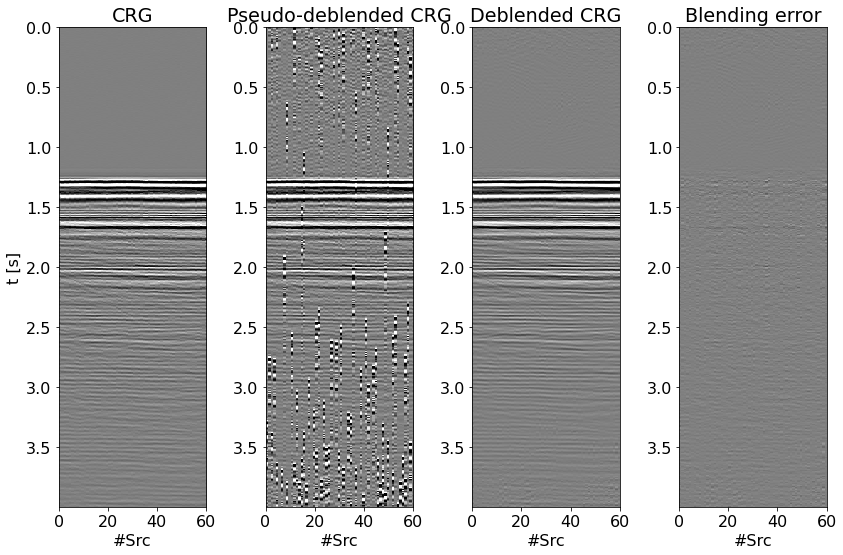

In [4]:
# Patched FK
dimsd = data.shape
nwin = (20, 80)
nover = (10, 40)
nop = (128, 128)
nop1 = (128, 65)
nwins = (5, 24)
dims = (nwins[0] * nop1[0], nwins[1] * nop1[1])

Fop = FFT2D(nwin, nffts=nop, real=True)
Sop = Patch2D(
    Fop.H, dims, dimsd, nwin, nover, nop1, tapertype="hanning",
)
# Overall operator
Op = Bop * Sop

# Compute max eigenvalue (we do this explicitly to be able to run this fast)
Op1 = LinearOperator(Op.H * Op, explicit=False)
X = np.random.rand(Op1.shape[0], 1).astype(Op1.dtype)
maxeig = sp_lobpcg(Op1, X=X, maxiter=5, tol=1e-10)[0][0]
alpha = 1.0 / maxeig

# Deblend
niter = 60
decay = (np.exp(-0.05 * np.arange(niter)) + 0.2) / 1.2

p_inv = fista(
    Op,
    data_blended.ravel(),
    niter=niter,
    eps=5e0,
    alpha=alpha,
    decay=decay,
    show=True,
)[0]
data_inv = Sop * p_inv
data_inv = data_inv.reshape(ns, nt)

fig, axs = plt.subplots(1, 4, sharey=False, figsize=(12, 8))
axs[0].imshow(
    data.T.real,
    cmap="gray",
    extent=(0, ns, t[-1], 0),
    vmin=-50,
    vmax=50,
    interpolation="none",
)
axs[0].set_title("CRG")
axs[0].set_xlabel("#Src")
axs[0].set_ylabel("t [s]")
axs[0].axis("tight")
axs[1].imshow(
    data_pseudo.squeeze().T.real,
    cmap="gray",
    extent=(0, ns, t[-1], 0),
    vmin=-50,
    vmax=50,
    interpolation="none",
)
axs[1].set_title("Pseudo-deblended CRG")
axs[1].set_xlabel("#Src")
axs[1].axis("tight")
axs[2].imshow(
    data_inv.T.real,
    cmap="gray",
    extent=(0, ns, t[-1], 0),
    vmin=-50,
    vmax=50,
    interpolation="none",
)
axs[2].set_xlabel("#Src")
axs[2].set_title("Deblended CRG")
axs[2].axis("tight")
axs[3].imshow(
    data.T.real - data_inv.T.real,
    cmap="gray",
    extent=(0, ns, t[-1], 0),
    vmin=-50,
    vmax=50,
    interpolation="none",
)
axs[3].set_xlabel("#Src")
axs[3].set_title("Blending error")
axs[3].axis("tight")
plt.tight_layout()

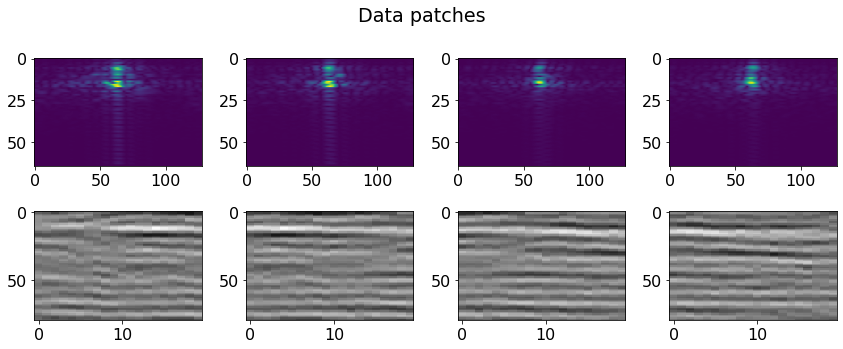

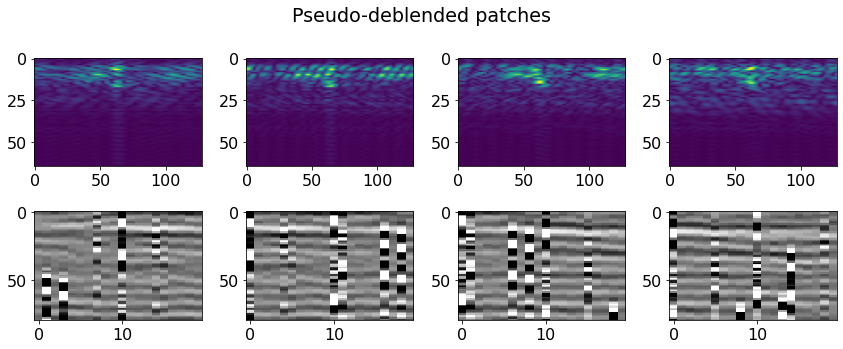

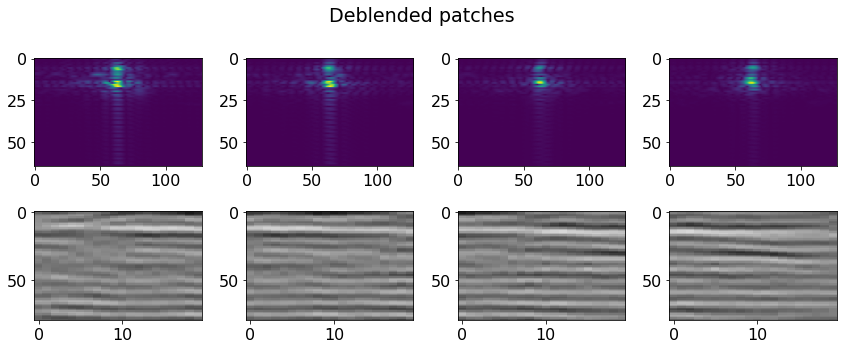

In [5]:
Sop1 = Patch2D(
    Fop.H, dims, dimsd, nwin, nover, nop1, tapertype=None,
)

# Original
p = Sop1.H * data.ravel()
preshape = p.reshape(nwins[0], nwins[1], nop1[0], nop1[1])

ix = 16
fig, axs = plt.subplots(2, 4, figsize=(12, 5))
fig.suptitle("Data patches")
for i in range(4):
    axs[0][i].imshow(np.fft.fftshift(np.abs(preshape[i, ix]).T, axes=1))
    axs[0][i].axis("tight")
    axs[1][i].imshow(
        np.real((Fop.H * preshape[i, ix].ravel()).reshape(nwin)).T,
        cmap="gray",
        vmin=-30,
        vmax=30,
        interpolation="none",
    )
    axs[1][i].axis("tight")
plt.tight_layout()

# Pseudo-deblended
p_pseudo = Sop1.H * data_pseudo.ravel()
p_pseudoreshape = p_pseudo.reshape(nwins[0], nwins[1], nop1[0], nop1[1])

ix = 16
fig, axs = plt.subplots(2, 4, figsize=(12, 5))
fig.suptitle("Pseudo-deblended patches")
for i in range(4):
    axs[0][i].imshow(np.fft.fftshift(np.abs(p_pseudoreshape[i, ix]).T, axes=1))
    axs[0][i].axis("tight")
    axs[1][i].imshow(
        np.real((Fop.H * p_pseudoreshape[i, ix].ravel()).reshape(nwin)).T,
        cmap="gray",
        vmin=-30,
        vmax=30,
        interpolation="none",
    )
    axs[1][i].axis("tight")
plt.tight_layout()

# Deblended
p_inv = Sop1.H * data_inv.ravel()
p_invreshape = p_inv.reshape(nwins[0], nwins[1], nop1[0], nop1[1])

ix = 16
fig, axs = plt.subplots(2, 4, figsize=(12, 5))
fig.suptitle("Deblended patches")
for i in range(4):
    axs[0][i].imshow(np.fft.fftshift(np.abs(p_invreshape[i, ix]).T, axes=1))
    axs[0][i].axis("tight")
    axs[1][i].imshow(
        np.real((Fop.H * p_invreshape[i, ix].ravel()).reshape(nwin)).T,
        cmap="gray",
        vmin=-30,
        vmax=30,
        interpolation="none",
    )
    axs[1][i].axis("tight")
plt.tight_layout()

## Group blending (2 sources)

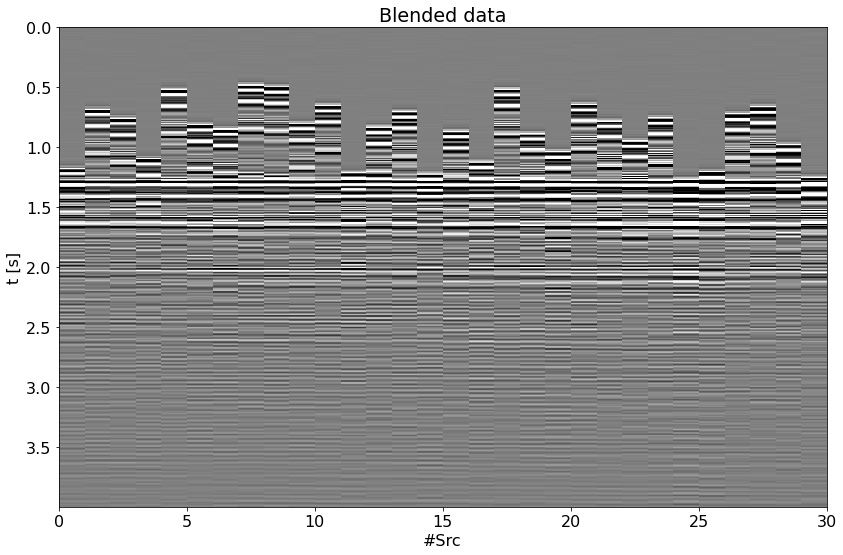

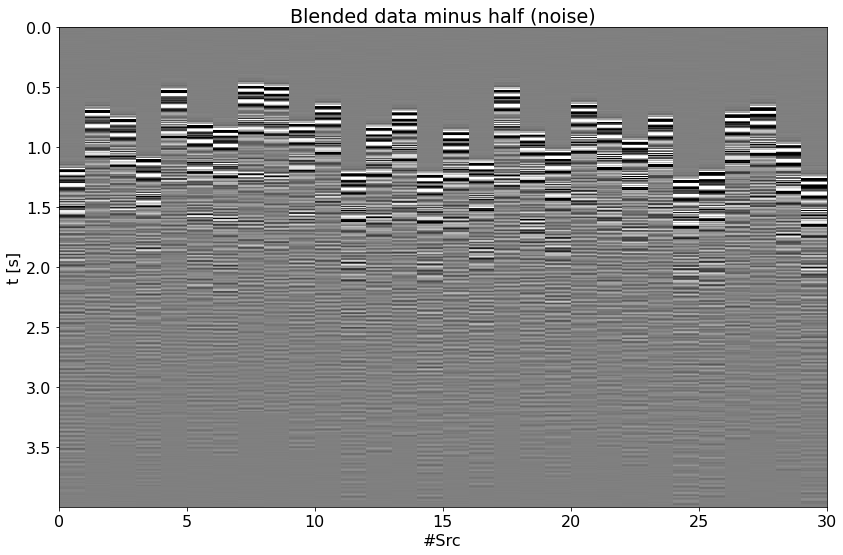

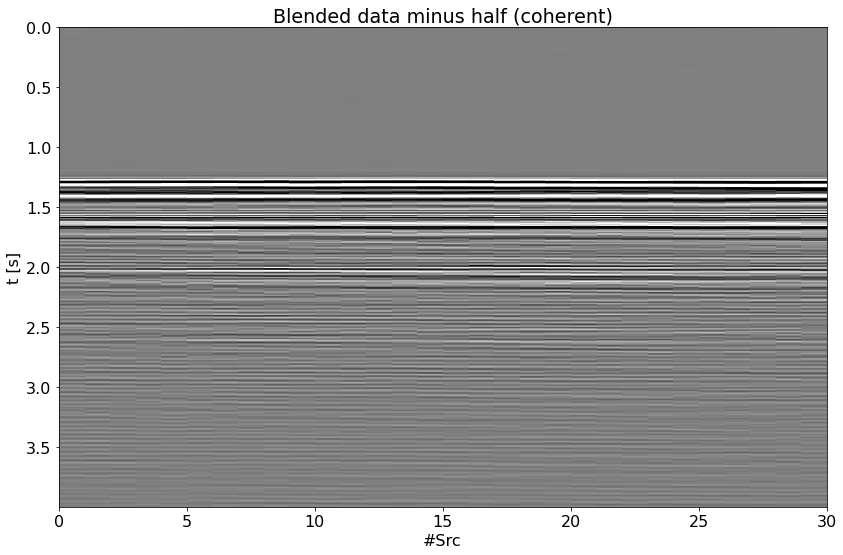

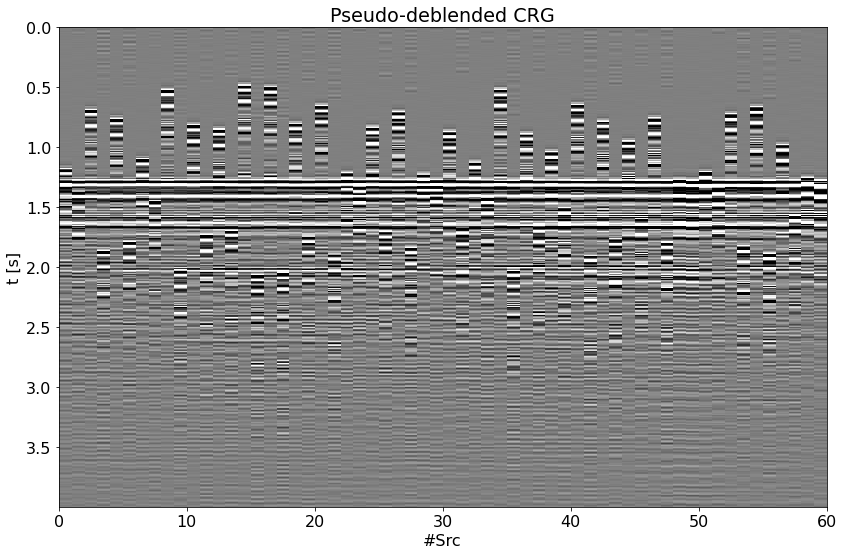

In [6]:
group_size = 2
n_groups = ns//group_size
ignition_times = 0.8*np.random.rand(ns)#-0.2 + 0.4*np.random.rand(ns)
ignition_times[::2] = 0.

Bop = BlendingGroup(nt, 1, ns, dt, 
                    -ignition_times.reshape(n_groups, group_size).T,
                    group_size=group_size, n_groups=n_groups, 
                    dtype="complex128")
data_blended = Bop * data[:, np.newaxis]
data_blended_minushalf = data_blended.squeeze() - data[::2]
data_pseudo = Bop.H * data_blended

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(
    data_blended.squeeze().T.real,
    cmap="gray",
    vmin=-50,
    vmax=50,
    extent=(0, n_groups, t[-1], 0),
    interpolation="none",
)
ax.set_title("Blended data")
ax.set_xlabel("#Src")
ax.set_ylabel("t [s]")
ax.axis("tight")
plt.tight_layout()

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(
    data_blended_minushalf.T.real,
    cmap="gray",
    vmin=-50,
    vmax=50,
    extent=(0, n_groups, t[-1], 0),
    interpolation="none",
)
ax.set_title("Blended data minus half (noise)")
ax.set_xlabel("#Src")
ax.set_ylabel("t [s]")
ax.axis("tight")
plt.tight_layout()

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(
    (data_blended.squeeze()-data_blended_minushalf).T.real,
    cmap="gray",
    vmin=-50,
    vmax=50,
    extent=(0, n_groups, t[-1], 0),
    interpolation="none",
)
ax.set_title("Blended data minus half (coherent)")
ax.set_xlabel("#Src")
ax.set_ylabel("t [s]")
ax.axis("tight")
plt.tight_layout()

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(
    data_pseudo.squeeze().T.real,
    cmap="gray",
    vmin=-50,
    vmax=50,
    extent=(0, ns, t[-1], 0),
    interpolation="none",
)
ax.set_title("Pseudo-deblended CRG")
ax.set_xlabel("#Src")
ax.set_ylabel("t [s]")
ax.axis("tight")
plt.tight_layout()


FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 30000 rows and 998400 cols
eps = 5.000000e+00	tol = 1.000000e-10	niter = 60
alpha = 4.964544e-01	thresh = 1.241136e+00
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1   0.00e+00+0.00e+00j    1.956e+06   4.158e+06   1.950e+03
     2   0.00e+00+0.00e+00j    9.336e+05   3.675e+06   7.026e+02
     3   0.00e+00+0.00e+00j    5.346e+05   3.464e+06   4.933e+02
     4   0.00e+00+0.00e+00j    3.688e+05   3.293e+06   3.877e+02
     5   0.00e+00+0.00e+00j    2.914e+05   3.125e+06   3.414e+02
     6   0.00e+00+0.00e+00j    2.490e+05   2.967e+06   3.182e+02
     7   0.00e+00+0.00e+00j    2.216e+05   2.828e+06   3.010e+02
     8   0.00e+00+0.00e+00j    2.012e+05   2.712e+06   2.846e+02
     9   0.00e+00+0.00e+00j    1.846e+05   2.617e+06   2.686e+02
    10   0.00e+00+0.00e

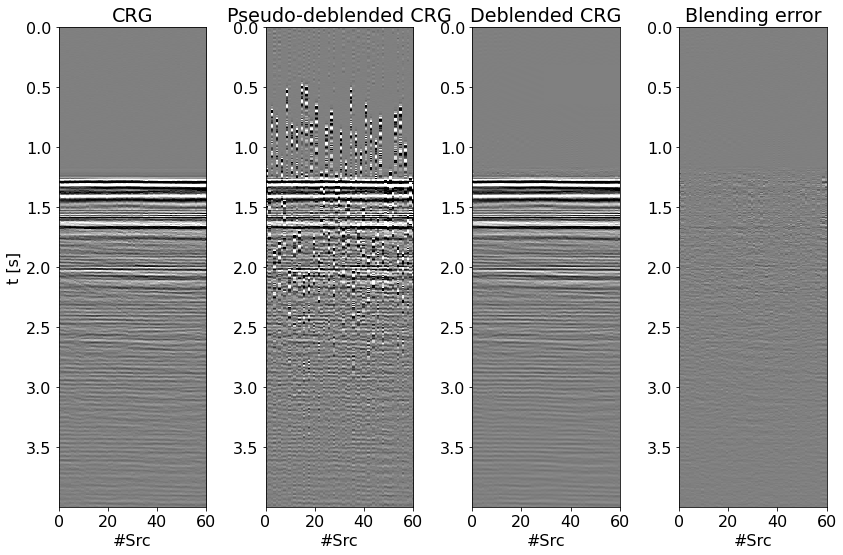

In [7]:
# Patched FK
dimsd = data.shape
nwin = (20, 80)
nover = (10, 40)
nop = (128, 128)
nop1 = (128, 65)
nwins = (5, 24)
dims = (nwins[0] * nop1[0], nwins[1] * nop1[1])

Fop = FFT2D(nwin, nffts=nop, real=True)
Sop = Patch2D(
    Fop.H, dims, dimsd, nwin, nover, nop1, tapertype="hanning", 
)
# Overall operator
Op = Bop * Sop

# Compute max eigenvalue (we do this explicitly to be able to run this fast)
Op1 = LinearOperator(Op.H * Op, explicit=False)
X = np.random.rand(Op1.shape[0], 1).astype(Op1.dtype)
maxeig = sp_lobpcg(Op1, X=X, maxiter=5, tol=1e-10)[0][0]
alpha = 1.0 / maxeig

# Deblend
niter = 60
decay = (np.exp(-0.05 * np.arange(niter)) + 0.2) / 1.2

p_inv = fista(
    Op,
    data_blended.ravel(),
    niter=niter,
    eps=5e0,
    alpha=alpha,
    decay=decay,
    show=True,
)[0]
data_inv = Sop * p_inv
data_inv = data_inv.reshape(ns, nt)

fig, axs = plt.subplots(1, 4, sharey=False, figsize=(12, 8))
axs[0].imshow(
    data.T.real,
    cmap="gray",
    extent=(0, ns, t[-1], 0),
    vmin=-50,
    vmax=50,
    interpolation="none",
)
axs[0].set_title("CRG")
axs[0].set_xlabel("#Src")
axs[0].set_ylabel("t [s]")
axs[0].axis("tight")
axs[1].imshow(
    data_pseudo.squeeze().T.real,
    cmap="gray",
    extent=(0, ns, t[-1], 0),
    vmin=-50,
    vmax=50,
    interpolation="none",
)
axs[1].set_title("Pseudo-deblended CRG")
axs[1].set_xlabel("#Src")
axs[1].axis("tight")
axs[2].imshow(
    data_inv.T.real,
    cmap="gray",
    extent=(0, ns, t[-1], 0),
    vmin=-50,
    vmax=50,
    interpolation="none",
)
axs[2].set_xlabel("#Src")
axs[2].set_title("Deblended CRG")
axs[2].axis("tight")
axs[3].imshow(
    data.T.real - data_inv.T.real,
    cmap="gray",
    extent=(0, ns, t[-1], 0),
    vmin=-50,
    vmax=50,
    interpolation="none",
)
axs[3].set_xlabel("#Src")
axs[3].set_title("Blending error")
axs[3].axis("tight")
plt.tight_layout()

## Group blending (3 sources)

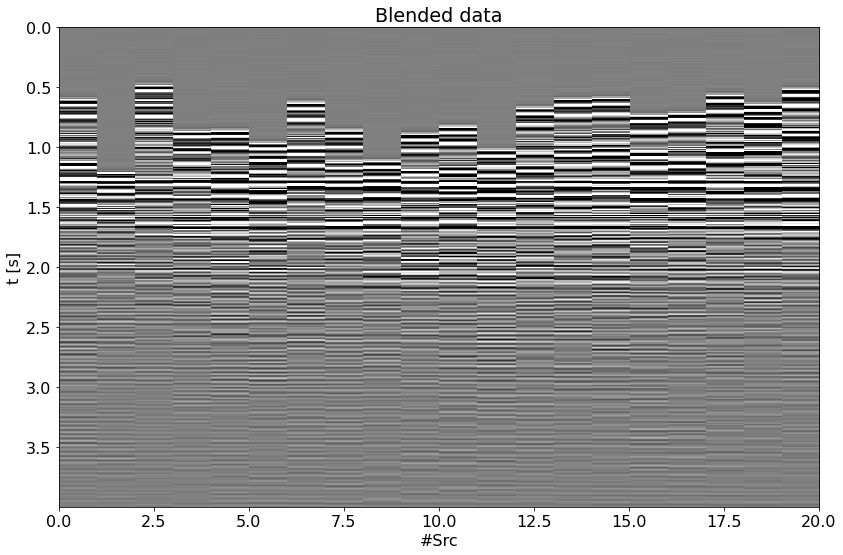

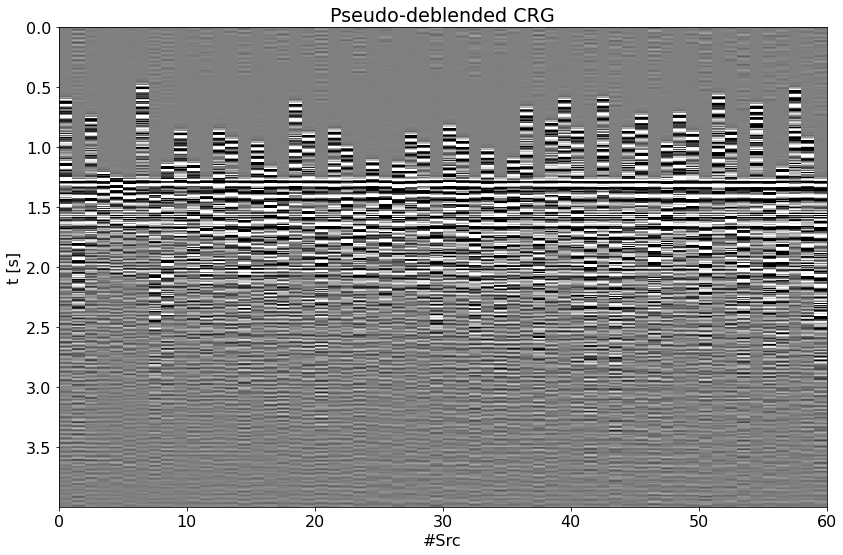

In [8]:
group_size = 3
n_groups = ns//group_size
#ignition_times = -0.2 + 0.4*np.random.rand(ns)
ignition_times = 0.8*np.random.rand(ns)#-0.2 + 0.4*np.random.rand(ns)
ignition_times[::3] = 0.

Bop = BlendingGroup(nt, 1, ns, dt, 
                    -ignition_times.reshape(n_groups, group_size).T,
                    group_size=group_size, n_groups=n_groups, 
                    dtype="complex128")
data_blended = Bop * data[:, np.newaxis]
data_pseudo = Bop.H * data_blended


fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(
    data_blended.squeeze().T.real,
    cmap="gray",
    vmin=-50,
    vmax=50,
    extent=(0, n_groups, t[-1], 0),
    interpolation="none",
)
ax.set_title("Blended data")
ax.set_xlabel("#Src")
ax.set_ylabel("t [s]")
ax.axis("tight")
plt.tight_layout()

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(
    data_pseudo.squeeze().T.real,
    cmap="gray",
    vmin=-50,
    vmax=50,
    extent=(0, ns, t[-1], 0),
    interpolation="none",
)
ax.set_title("Pseudo-deblended CRG")
ax.set_xlabel("#Src")
ax.set_ylabel("t [s]")
ax.axis("tight")
plt.tight_layout()

FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 20000 rows and 998400 cols
eps = 5.000000e+00	tol = 1.000000e-10	niter = 60
alpha = 1.633753e-01	thresh = 4.084382e-01
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1   0.00e+00+0.00e+00j    4.251e+06   5.308e+06   7.696e+02
     2   0.00e+00+0.00e+00j    2.499e+06   4.246e+06   5.242e+02
     3   0.00e+00+0.00e+00j    1.370e+06   3.697e+06   4.701e+02
     4   0.00e+00+0.00e+00j    7.421e+05   3.491e+06   3.835e+02
     5   0.00e+00+0.00e+00j    4.249e+05   3.438e+06   2.960e+02
     6   0.00e+00+0.00e+00j    2.729e+05   3.417e+06   2.262e+02
     7   0.00e+00+0.00e+00j    2.008e+05   3.381e+06   1.808e+02
     8   0.00e+00+0.00e+00j    1.660e+05   3.321e+06   1.564e+02
     9   0.00e+00+0.00e+00j    1.484e+05   3.248e+06   1.449e+02
    10   0.00e+00+0.00e

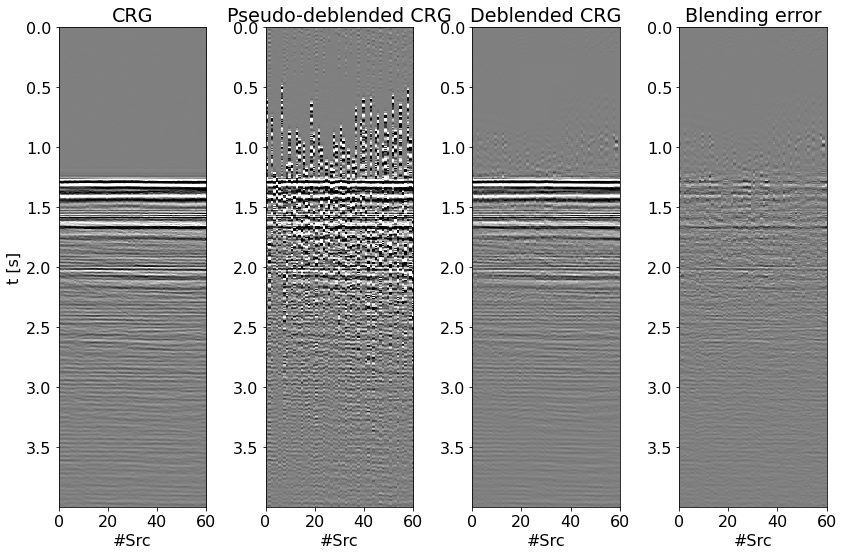

In [9]:
# Patched FK
dimsd = data.shape
nwin = (20, 80)
nover = (10, 40)
nop = (128, 128)
nop1 = (128, 65)
nwins = (5, 24)
dims = (nwins[0] * nop1[0], nwins[1] * nop1[1])

Fop = FFT2D(nwin, nffts=nop, real=True)
Sop = Patch2D(
    Fop.H, dims, dimsd, nwin, nover, nop1, tapertype="hanning",
)
# Overall operator
Op = Bop * Sop

# Compute max eigenvalue (we do this explicitly to be able to run this fast)
Op1 = LinearOperator(Op.H * Op, explicit=False)
X = np.random.rand(Op1.shape[0], 1).astype(Op1.dtype)
maxeig = sp_lobpcg(Op1, X=X, maxiter=5, tol=1e-10)[0][0]
alpha = 1.0 / maxeig

# Deblend
niter = 60
decay = (np.exp(-0.05 * np.arange(niter)) + 0.2) / 1.2

p_inv = fista(
    Op,
    data_blended.ravel(),
    niter=niter,
    eps=5e0,
    alpha=alpha,
    decay=decay,
    show=True,
)[0]
data_inv = Sop * p_inv
data_inv = data_inv.reshape(ns, nt)

fig, axs = plt.subplots(1, 4, sharey=False, figsize=(12, 8))
axs[0].imshow(
    data.T.real,
    cmap="gray",
    extent=(0, ns, t[-1], 0),
    vmin=-50,
    vmax=50,
    interpolation="none",
)
axs[0].set_title("CRG")
axs[0].set_xlabel("#Src")
axs[0].set_ylabel("t [s]")
axs[0].axis("tight")
axs[1].imshow(
    data_pseudo.squeeze().T.real,
    cmap="gray",
    extent=(0, ns, t[-1], 0),
    vmin=-50,
    vmax=50,
    interpolation="none",
)
axs[1].set_title("Pseudo-deblended CRG")
axs[1].set_xlabel("#Src")
axs[1].axis("tight")
axs[2].imshow(
    data_inv.T.real,
    cmap="gray",
    extent=(0, ns, t[-1], 0),
    vmin=-50,
    vmax=50,
    interpolation="none",
)
axs[2].set_xlabel("#Src")
axs[2].set_title("Deblended CRG")
axs[2].axis("tight")
axs[3].imshow(
    data.T.real - data_inv.T.real,
    cmap="gray",
    extent=(0, ns, t[-1], 0),
    vmin=-50,
    vmax=50,
    interpolation="none",
)
axs[3].set_xlabel("#Src")
axs[3].set_title("Blending error")
axs[3].axis("tight")
plt.tight_layout()